In [ ]:
from typing import Literal
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage
from langgraph.types import Command
from pydantic import BaseModel, Field
from langchain_tavily import TavilySearch
from langgraph.prebuilt import create_react_agent
from langchain_mcp_adapters.client import MultiServerMCPClient
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.runnables import RunnableConfig
from langgraph.graph import StateGraph, START, END, MessagesState

load_dotenv()

llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
)
memory = MemorySaver()

In [2]:
class VAModel(BaseModel):
    next: Literal["research_agent", "todo_agent", "enhancer_agent"] = Field(
        description="Determines which specialist to activate next in the workflow sequence: "
                    "'enhancer_agent' when user input requires clarification, expansion, or refinement, "
                    "'research_agent' when additional facts, context, or data collection is necessary, "
                    "'todo_agent' when the task involves todo & todo collection management (adding, completing, listing, or deleting todos)."
    )
    reason: str = Field(
        description="Detailed justification for the routing decision, explaining the rationale behind selecting the particular specialist and how this advances the task toward completion."
    )


def va_agent(state: MessagesState) -> Command[Literal["research_agent", "todo_agent", "enhancer_agent"]]:

    system_prompt = ('''
        You are a workflow supervisor managing a team of three specialized agents: Prompt Enhancer, Researcher, and Todo Agent. 
        Your role is to orchestrate the workflow by selecting the most appropriate next agent based on the current state and needs of the task. 
        Provide a clear, concise rationale for each decision to ensure transparency in your decision-making process.

        **Team Members**:
        1. **Prompt Enhancer**: Always consider this agent first. They clarify ambiguous requests, improve poorly defined queries, and ensure the task is well-structured before deeper processing begins.
        2. **Researcher**: Specializes in information gathering, fact-finding, and collecting relevant data needed to address the user's request.
        3. **Todo Agent**: Handles anything related to todo management, such as adding, completing, listing, or deleting tasks, as well as organizing todo collections.

        **Your Responsibilities**:
        1. Analyze each user request and agent response for completeness, accuracy, and relevance.
        2. Route the task to the most appropriate agent at each decision point.
        3. Maintain workflow momentum by avoiding redundant agent assignments.
        4. Continue the process until the user's request is fully and satisfactorily resolved.

        Your objective is to create an efficient workflow that leverages each agent's strengths while minimizing unnecessary steps, ultimately delivering complete and accurate solutions to user requests.
    ''')

    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]

    response = llm.with_structured_output(VAModel).invoke(messages)

    goto = response.next  # type: ignore
    reason = response.reason  # type: ignore

    print(f"--- Workflow Transition: Supervisor → {goto.upper()} ---")

    return Command(
        update={
            "messages": [
                HumanMessage(content=reason, name="va_agent")
            ]
        },
        goto=goto,
    )

In [3]:
async def enhancer_agent(state: MessagesState) -> Command[Literal["va_agent"]]:
    """
        Enhancer agent node that improves and clarifies user queries.
        Takes the original user input and transforms it into a more precise,
        actionable request before passing it to the va_agent.
    """

    system_prompt = (
        "You are a Query Refinement Specialist with expertise in transforming vague requests into precise instructions. Your responsibilities include:\n\n"
        "1. Analyzing the original query to identify key intent and requirements\n"
        "2. Resolving any ambiguities without requesting additional user input\n"
        "3. Expanding underdeveloped aspects of the query with reasonable assumptions\n"
        "4. Restructuring the query for clarity and actionability\n"
        "5. Ensuring all technical terminology is properly defined in context\n\n"
        "Important: Never ask questions back to the user. Instead, make informed assumptions and create the most comprehensive version of their request possible."
    )

    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]

    enhanced_query = await llm.ainvoke(messages)

    print(f"--- Workflow Transition: Prompt Enhancer → Supervisor ---")

    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=enhanced_query.content,
                    name="enhancer_agent"
                )
            ]
        },
        goto="va_agent",
    )

In [18]:
async def research_agent(state: MessagesState):
    """Run a class todo agent using the react agent framework and a remote MCP server."""
    search_tool = TavilySearch(max_results=5)
    tools = [search_tool]
    graph = create_react_agent(
        "google_genai:gemini-2.0-flash",
        tools
    )

    # Create event stream
    result = await graph.ainvoke(state)

    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"]
                             [-1].content, name="research_agent")
            ]
        },
        goto=END,
    )

In [39]:
async def todo_agent(state: MessagesState):
    """Run a class todo agent using the react agent framework and a remote MCP server."""
    client = MultiServerMCPClient({
        "fastapi-mcp": {
            "url": "http://localhost:8000/mcp",
            "transport": "sse",
        }
    })  # type: ignore
    system_prompt = (
        "You are a helpful and intelligent Todo Agent. "
        "Your primary tasks include adding, completing, listing, and deleting todos, along with other todo-related actions. "
        "You have access to specialized tools: 'todo tools' and 'todo collection tools' to assist with these tasks. "
        "todos have ids etc , which identify them uniquely. so try use the ids when dealing on an individual todo. "
        "Before performing any action, first check your memory to see if the required information is already available. "
        "Only use a tool if the necessary data is not found in memory. "
        "When using a tool, be thoughtful and deliberate—choose the most appropriate tool for the specific task at hand. "
        "Use the tool name explicitly in your response when invoking a tool."
        "you don't need to ask the user any permission to use the tools, just use them as needed. especially the todo tools."
    )

    remote_tools = await client.get_tools()
    graph = create_react_agent(
        "google_genai:gemini-2.0-flash",
        tools=remote_tools,
        prompt=system_prompt,
    )

    # Create event stream
    result = await graph.ainvoke(state)

    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"]
                             [-1].content, name="todo_agent")
            ]
        },
        goto=END,
    )

In [ ]:
# Create the stateful graph
builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("va_agent", va_agent)
builder.add_node("enhancer_agent", enhancer_agent)
builder.add_node("research_agent", research_agent)
builder.add_node("todo_agent", todo_agent)

# Define entry point
builder.add_edge(START, "va_agent")


# Build the graph
checkpointer = MemorySaver()
graph = builder.compile(checkpointer=checkpointer)

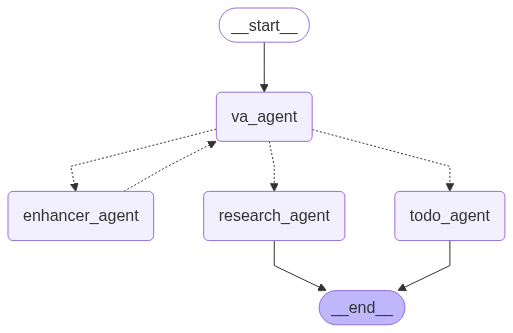

In [14]:
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(f"Error displaying graph: {e}")
    pass

In [41]:
import uuid

thread_config = RunnableConfig(
    {"configurable": {
        "thread_id": 24,
    }}
)

inputs = {
        "messages": [
            HumanMessage(
                content="delete bug fixing task, we are not fixing bugs anymore",
            ),
        ]
    }

events = graph.astream_events(input=inputs, config=thread_config, version="v2")

async for event in events:
    if event["event"] == "on_chat_model_stream":
        print(event["data"]["chunk"].content, end="", flush=True)

--- Workflow Transition: Supervisor → TODO_AGENT ---
It seems like I need the todo ID to delete the "Bug Fixing" task. I'll use the todo tools to find the ID first.
My apologies, I need the todo ID to delete the 'Bug Fixing' task. I will retrieve all of your todos with their IDs first. Then, I will delete the 'Bug Fixing' task using its ID.
OK. I have removed 'Bug Fixing' from your todo list.


Task todo_agent with path ('__pregel_pull', 'todo_agent') wrote to unknown channel branch:to:__end__, ignoring it.
